<a href="https://colab.research.google.com/github/Keerat-Grewal/StockAnalysis/blob/main/StockML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installed all libraries needed
!pip3 install yfinance
!ls
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib')
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

     |████████████████████████████████| 5.5MB 7.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=664ef27a24c19dbcf476ea9a90cbcd0154f98d9a30cff634a977b3ae17569dd8
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
sample_data
--2020-12-21 23:09:10--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-12-21 23:09:10--  http://downloads.sourceforge.net/project/ta-lib/ta-l

In [2]:
import numpy as np
from talib import abstract
import plotly.graph_objects as go
import matplotlib.dates as mpl_dates
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
import copy
import time

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# basic stock class
class Stock:

    def __init__(self, ticker, period, interval):
        self.ticker = yf.Ticker(ticker)
        self.stock_data = self.ticker.history(period=period, interval=interval)
        self.stock_data["Date"] = pd.to_datetime(self.stock_data.index)
        self.stock_data["Date"] = self.stock_data["Date"].apply(mpl_dates.date2num)
        self.closing_prices = self.stock_data["Close"]
        # remove unnecessary columns
        self.stock_data = self.stock_data.drop(['Dividends', 'Stock Splits'], axis=1)


    def get_MA(self, timeperiod):
        MA = abstract.Function('ma')
        res = MA(self.closing_prices, timeperiod=timeperiod)
        # try to add to pandas series frame here
        title = f"MA {timeperiod}"
        self.stock_data[title] = res
        return res


    def get_MACD(self):
        MACD = abstract.Function('macd')
        macd, macdsignal, macdhist = MACD(self.closing_prices, fastperiod=12, slowperiod=26, signalperiod=9)
        self.stock_data["MACD"] = macd
        self.stock_data["MACD signal"] = macdsignal
        self.stock_data["MACD hist"] = macdhist
        return macd, macdsignal, macdhist


    def get_RSI(self):
        RSI = abstract.Function('rsi')
        res = RSI(self.closing_prices, timeperiod=14)
        self.stock_data["RSI"] = res
        return res


In [5]:
def create_model(X_train, y_train):
    # create model
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(11))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

    return model


def setup_data(stock, scalar):
    # split up data 90% training, 10% testing
    data = stock.stock_data.dropna(thresh=12)
    data = data.drop('Date', axis=1)
    data = data.values
    split = int(0.9 * len(data))
    training_set = data[:split, :]
    test_set = data[split:, :]

    # normalize training data to make it easier for training process
    training_set_scaled = scalar.fit_transform(training_set)

    X_train = []
    y_train = []

    for i in range(60, len(training_set_scaled)):
        component = []
        for j in range(i - 60, i):
            for k in range(len(training_set_scaled[j])):
                component.append(training_set_scaled[j][k])
        # this component will contain all the 11 indicators to predict the current price @ i
        actual_component = []
        counter = 0
        for q in range(60):
            item = component[counter:counter+11]
            actual_component.append(item)
            counter += 11
        X_train.append(actual_component)
        y_train.append(training_set_scaled[i, :])

    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train, test_set, training_set

                  Open        High  ...  MACD hist        RSI
Date                                ...                      
2003-01-23  126.980003  127.110001  ...        NaN        NaN
2003-01-24  126.900002  127.760002  ...        NaN        NaN
2003-01-27  127.589996  128.940002  ...        NaN        NaN
2003-01-28  128.460007  128.720001  ...        NaN        NaN
2003-01-29  128.460007  128.619995  ...        NaN        NaN
...                ...         ...  ...        ...        ...
2020-12-15  126.359001  126.584000  ...   0.096322  63.623917
2020-12-16  125.963997  126.344002  ...   0.045751  58.676382
2020-12-17  126.186996  126.413002  ...   0.021826  60.692114
2020-12-18  126.473000  127.000000  ...   0.016893  62.781274
2020-12-21  126.330002  126.553001  ...   0.001236  61.544990

[4627 rows x 12 columns]
Epoch 1/100
123/123 - 9s - loss: 0.0364
Epoch 2/100
123/123 - 6s - loss: 0.0119
Epoch 3/100
123/123 - 6s - loss: 0.0091
Epoch 4/100
123/123 - 6s - loss: 0.0071
Epoch 5/

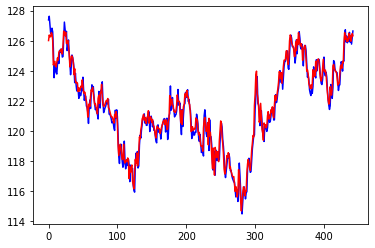

In [6]:
    # create a stock
    stock = Stock("EURJPY=X", "max", "1d")

    # get moving average, MACD, and RSI for stock
    stock.get_MA(50)
    stock.get_MA(200)
    stock.get_MACD()
    stock.get_RSI()

    # get real price for stock
    real_price = stock.stock_data
    print(real_price)
    real_price = real_price.drop('Date', axis=1)
    real_price = real_price["Open"].values

    # create scaler for normalization
    scalar = MinMaxScaler(feature_range=(0, 1))

    # setup training and testing set
    X_train, y_train, test_set, training_set = setup_data(stock, scalar)
    
    # get LSTM model
    model = create_model(X_train, y_train)

    # setting up test set
    new_test_set = []
    for i in range(len(training_set) - 1, len(training_set) - 61, -1):
        new_test_set.append(training_set[i])

    for j in range(len(test_set)):
        new_test_set.append(test_set[j])
    test_set = copy.deepcopy(new_test_set)
    test_set_scaled = scalar.transform(test_set)

    X_test = []
    for i in range(60, len(test_set_scaled) + 1):
        component = []
        for j in range(i - 60, i):
            for k in range(len(test_set_scaled[j])):
                component.append(test_set_scaled[j][k])
        # this component will contain all the 11 indicators to predict the current price @ i
        actual_component = []
        counter = 0
        for q in range(60):
            item = component[counter:counter+11]
            actual_component.append(item)
            counter += 11
        X_test.append(actual_component)
    #print(X_test[1])
    X_test = np.array(X_test)

    # made price predictions
    model_prediction = model.predict(X_test)
    predicted_price = scalar.inverse_transform(model_prediction)[:, 0]
    #print(len(predicted_price))
    predicted_next_day_open = predicted_price[-1]
    predicted_price = predicted_price[:-1]
    #print(len(predicted_price))

    # save the model
    t = time.time()
    export_path_keras = "./{}.h5".format("100day")
    model.save(export_path_keras)

    print(predicted_price)
    print(real_price)
    print(f"Predicted next day open: {predicted_next_day_open}")

    # plot results : Predicted vs. Actual
    plt.plot(predicted_price, color="blue", label="Predicted price")
    plt.plot(real_price[len(real_price) - len(predicted_price):], color="red", label="Actual price")
    plt.show()
